<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/PINN_vdPol_classico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.integrate import solve_ivp

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.utils import plot_model

print('Versão do TensorFlow:', tf.__version__)

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
tf.random.set_seed(2024)

# Aumenta o tamanho da fonte para 14
plt.rcParams['font.size'] = 14
# Define o grid como visível
plt.rcParams['axes.grid'] = True

Versão do TensorFlow: 2.15.0


In [2]:
# prompt: create a function called parameters_to_1D_vector, which should take model.trainable_variables (weights and biases) and return a 1D vector.

def parameters_to_1D_vector(weights_and_biases):
  """
  Converts a list of weights and biases to a 1D vector.

  Args:
    weights_and_biases: A list of weights and biases.

  Returns:
    A 1D vector containing the weights and biases.
  """
  # Concatenate the weights and biases into a single vector.
  vector = tf.concat([tf.reshape(w, [-1]) for w in weights_and_biases], axis=0)
  return tf.cast(vector, tf.float32)


# prompt: create a function taking the 1D vector and update its shape to match the  model.trainable_variables.

def update_model_weights(net, weights_1D_vector):
  """
  Updates the weights and biases of the model from a 1D vector.

  Args:
    weights_1D_vector: A 1D vector containing the weights and biases.
  """
  # Split the vector into the weights and biases.
  weights_and_biases = []
  start = 0
  for w in net.trainable_variables:
    shape = w.shape
    size = tf.reduce_prod(shape)
    weights_and_biases.append(tf.reshape(weights_1D_vector[start:start + size], shape))
    start += size

  # Update the weights and biases of the model.
  for i, w in enumerate(net.trainable_variables):
    net.trainable_variables[i].assign(weights_and_biases[i])

# Sistema van der Pol

In [3]:
def f(t, y1, y2):
  u = 0.5
  f1 = y2
  f2 = (1-y1**2) * y2 - y1 + u
  return tf.concat((f1,f2),1)

# Ajuste de uma PINN clássica

## Criando o modelo NN

In [4]:
N_layers = 5
N_neurons = 50
model = tf.keras.Sequential()
for i in range(N_layers):
  model.add(Dense(N_neurons, activation='tanh'))
model.add(Dense(2))
model.build(input_shape=(1,1))

## Dado de treinamento da condição inicial

In [5]:
# criando a condição inicial
u0 = 0.5
y0 = [0.3, -1.5]
t_train = tf.zeros((1,1))
y_train = tf.reshape(y0, (1,2))

# Usando o modelo NN
y = model(t_train)

# Calculando a função de perda
MSE_y0 = tf.reduce_mean((y-y_train)**2)
print(y.numpy(), y_train.numpy(), MSE_y0.numpy())

[[0. 0.]] [[ 0.3 -1.5]] 1.17


## Pontos de colocação

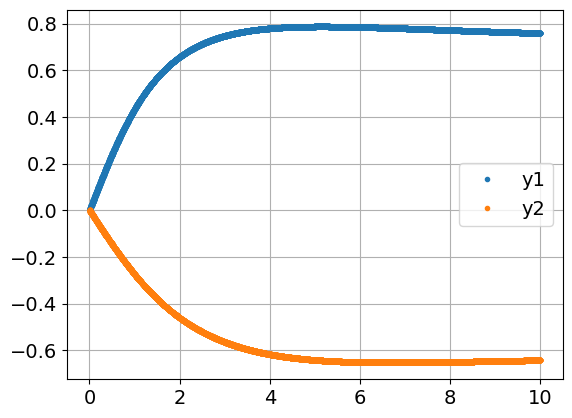

In [6]:
T = 10
N_f = int(1000 * T)
# criando amostras randômicas
t_collocation = tf.random.uniform((N_f,1), 0, T)

# testando o modelo
y_collocation = model(t_collocation)
plt.plot(t_collocation, y_collocation, '.')
plt.legend(['y1', 'y2']);

## Calcular a perda de cada ponto de colocação

In [7]:
@tf.function
def system_loss(net, input):

    with tf.GradientTape(persistent=True) as tape:
      tape.watch(input)
      output = net(input)

      y1 = tf.reshape(output[:,0], (N_f,1))
      y2 = tf.reshape(output[:,1], (N_f,1))

    y1_t = tape.gradient(y1, input)
    y2_t = tape.gradient(y2, input)
    del tape

    # Resíduo e perda do modelo
    y_t = tf.concat((y1_t, y2_t),1)
    F = y_t - f(input, y1, y2)
    MSE_F = tf.reduce_mean(F**2)

    # Predição dos dados de treinamento
    y_hat = net(t_train)

    # Perda no treinamento
    MSE_y = tf.reduce_mean((y_hat-y_train)**2)

    return MSE_F + MSE_y

## Loop de treinamento: Adam com L-BFGS

In [8]:
# Define uma taxa de aprendizagem que muda ao longo do processo de treinamento
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,5000],[1e-2,1e-3,5e-4])

# Define o otimizador Adam, um algoritmo de otimização estocástica comum usado para treinar redes neurais.
# O AMSGrad é uma variante do otimizador Adam que pode oferecer algumas vantagens (estabilidade, rapidez, desempenho, ...), mas nem sempre é superior ao Adam.
optm = tf.keras.optimizers.Adam(learning_rate = lr,
                                beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

In [9]:
epochs = 10000
fun_hist = []
for i in range(epochs):
  with tf.GradientTape() as tape:
    loss = system_loss(model, t_collocation)

  gradients = tape.gradient(loss, model.trainable_variables)
  optm.apply_gradients(zip(gradients, model.trainable_variables))
  fun_hist.append(loss.numpy())


In [10]:
from scipy.optimize import fmin_l_bfgs_b

def f_val_and_grad(x):
  x = tf.cast(x, tf.float32)
  update_model_weights(model, x)

  with tf.GradientTape() as tape:
    loss = system_loss(model, t_collocation)

  gradients = tape.gradient(loss, model.trainable_variables)
  gradients_vec = parameters_to_1D_vector(gradients)
  fun_hist.append(loss.numpy())

  return loss, gradients_vec

initial_parameters = parameters_to_1D_vector(model.trainable_variables)

x = fmin_l_bfgs_b(f_val_and_grad, initial_parameters, maxiter=epochs)

Text(0, 0.5, 'Total loss')

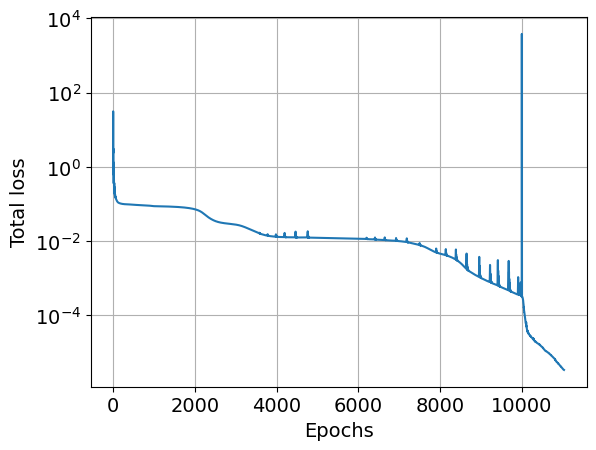

In [11]:
update_model_weights(model, tf.cast(x[0], tf.float32))

plt.plot(fun_hist)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Total loss')

In [12]:
# Usando o modelo NN
y = model(t_train)

# Calculando a função de perda
MSE_y0 = tf.reduce_mean((y-y_train)**2)
print(y.numpy(), y_train.numpy(), MSE_y0.numpy())

[[ 0.300027  -1.4999892]] [[ 0.3 -1.5]] 4.2336445e-10


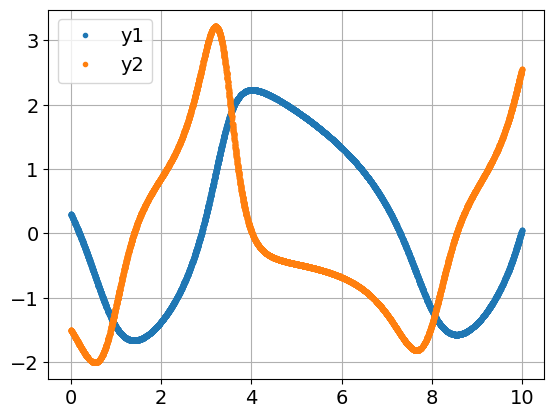

In [13]:
# testando o modelo
y_collocation = model(t_collocation)
plt.plot(t_collocation, y_collocation, '.')
plt.legend(['y1', 'y2']);

## Simulando com solve_ivp

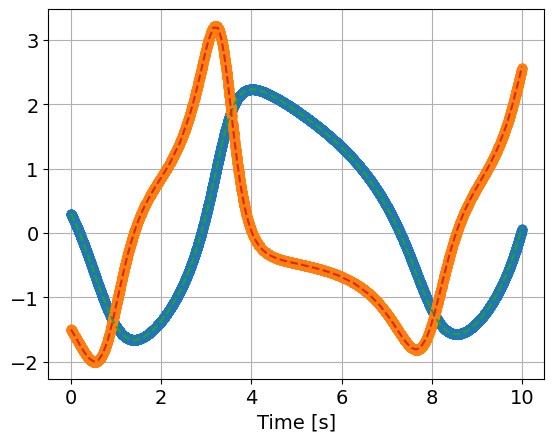

In [14]:
def f_ivp(t, x, u):
  y1, y2 = x
  f1 = y2
  f2 = (1-y1**2) * y2 - y1 + u
  return [f1,f2]

# intervalo de integração
tspan = [0, 10]
time = np.linspace(*tspan, 21)

# condição inicial
x0 = [0.3, -1.5]
u0 = 0.5

# instanciando o modelo
model = lambda t, x: f_ivp(t, x, u0)

# obtendo resultados
sol = solve_ivp(model, tspan, x0, method='BDF')

ts = sol.t
x = sol.y

# visualizando os pontos
plt.plot(t_collocation, y_collocation, 'o')
plt.plot(ts, x[0,:], '--')
plt.plot(ts, x[1,:], '--')
plt.xlabel('Time [s]');